In [1]:
import rdata
import pandas as pd
from skfda.representation.basis import FourierBasis, BSplineBasis
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.optim as optim

# Generate Date Labels

In [4]:
from datetime import datetime, timedelta

def generate_dates(start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, "%d/%m/%Y")
    end_date = datetime.strptime(end_date_str, "%d/%m/%Y")
    date_list = []
    one_day = timedelta(days=1)
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += one_day
    return date_list

# Function to get the season
def get_season(date):
    seasons = {
        'Summer': (12, 1, 2),
        'Autumn': (3, 4, 5),
        'Winter': (6, 7, 8),
        'Spring': (9, 10, 11)
    }
    month = date.month
    for season, months in seasons.items():
        if month in months:
            return season
    return 'Unknown'

# Function to map dates to seasons
def map_dates_to_seasons(dates):
    return [get_season(date) for date in dates]

# Create the DataFrame with one-hot encoding for seasons
def create_season_df(start_date, end_date):
    dates = generate_dates(start_date, end_date)
    seasons = map_dates_to_seasons(dates)
    
    # Create a DataFrame with seasons
    df = pd.DataFrame(dates, columns=['Date'])
    df['Season'] = seasons
    
    # Convert seasons into one-hot encoding
    df = pd.get_dummies(df, columns=['Season'])
    
    return df

# Date range for the Adelaide data
start_date = "06/07/1997"
end_date = "31/03/2007"

# Create the DataFrame
season_df = create_season_df(start_date, end_date)
print(season_df.head())
print(f"Total rows in DataFrame: {len(season_df)}")

        Date  Season_Autumn  Season_Spring  Season_Summer  Season_Winter
0 1997-07-06          False          False          False           True
1 1997-07-07          False          False          False           True
2 1997-07-08          False          False          False           True
3 1997-07-09          False          False          False           True
4 1997-07-10          False          False          False           True
Total rows in DataFrame: 3556


In [9]:
season_df['Season_Autumn'] = season_df['Season_Autumn'].apply(lambda x: float(x))
season_df['Season_Spring'] = season_df['Season_Spring'].apply(lambda x: float(x))
season_df['Season_Summer'] = season_df['Season_Summer'].apply(lambda x: float(x))
season_df['Season_Winter'] = season_df['Season_Winter'].apply(lambda x: float(x))
season_df = season_df[['Date', 'Season_Spring', 'Season_Summer', 'Season_Autumn', 'Season_Winter']]
season_df.to_csv('/Users/tomas/Repos/FNNs/data/labels/labels.csv', index=False)
season_df

,Date,Season_Spring,Season_Summer,Season_Autumn,Season_Winter
0,1997-07-06,0.0,0.0,0.0,1.0
1,1997-07-07,0.0,0.0,0.0,1.0
2,1997-07-08,0.0,0.0,0.0,1.0
3,1997-07-09,0.0,0.0,0.0,1.0
4,1997-07-10,0.0,0.0,0.0,1.0
...,...,...,...,...,...
3551,2007-03-27,0.0,0.0,1.0,0.0
3552,2007-03-28,0.0,0.0,1.0,0.0
3553,2007-03-29,0.0,0.0,1.0,0.0
3554,2007-03-30,0.0,0.0,1.0,0.0


# Temperature Data

All data was obtained using R’s fds package for functional data, which includes several datasets, with this being one of them. The dataset contains 3,556 curves, which is relatively small for training neural networks. To address this, we will increase the number of training epochs. Additionally, we will use a validation set to monitor for overfitting.

https://cran.r-project.org/web/packages/fds/fds.pdf

/var/folders/4s/27tq7phd6bvg75xgn1b9vk7w0000gn/T/ipykernel_20913/2052209032.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20b')


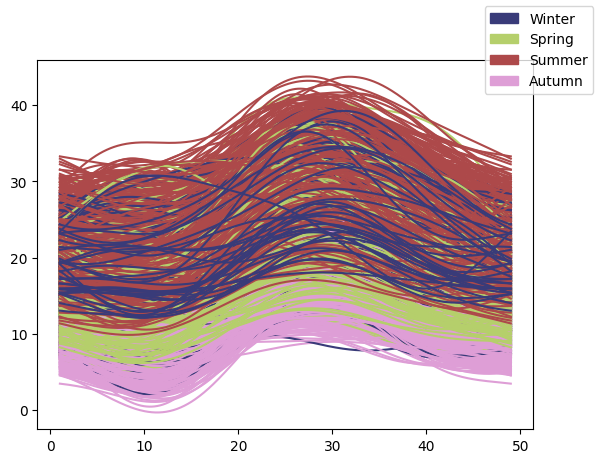

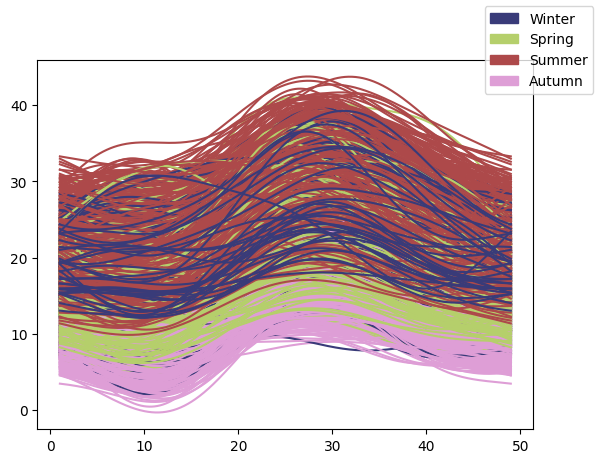

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skfda.representation.basis import FourierBasis
from skfda.representation.grid import FDataGrid
import pandas as pd
from datetime import datetime, timedelta

# Function to generate a list of dates
def generate_dates(start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, "%d/%m/%Y")
    end_date = datetime.strptime(end_date_str, "%d/%m/%Y")
    date_list = []
    one_day = timedelta(days=1)
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += one_day
    return date_list

# Function to get the season for Australia
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Summer'
    elif date.month in [3, 4, 5]:
        return 'Autumn'
    elif date.month in [6, 7, 8]:
        return 'Winter'
    elif date.month in [9, 10, 11]:
        return 'Spring'

# Create a DataFrame with a single column identifying the season
def create_season_df(start_date, end_date):
    dates = generate_dates(start_date, end_date)
    seasons = [get_season(date) for date in dates]
    
    # Create a DataFrame with dates and corresponding seasons
    df = pd.DataFrame({'Date': dates, 'Season': seasons})
    
    return df

# Define the date range
start_date = "06/07/1997"
end_date = "31/03/2007"

# Convert the 'Category' column to categorical and then to integer codes
season_df = create_season_df(start_date, end_date)
season_df['Category_Int'] = pd.Categorical(season_df['Season']).codes

# Assigning the color to each of the groups
colormap = plt.cm.get_cmap('tab20b')
unique_seasons = season_df['Season'].unique()
season_to_color = {season: colormap(i / (len(unique_seasons) - 1)) for i, season in enumerate(unique_seasons)}

# Convert the 'Season' string column to integer codes for grouping
season_df['Season_Int'] = season_df['Season'].astype('category').cat.codes

# Load temperature data
temp_data = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperatures/temp.csv').to_numpy()
temp_fd = FDataGrid(temp_data, range(1, 49))
temp_basis = FourierBasis(domain_range=(1, 49), n_basis=5)
fd = temp_fd.to_basis(temp_basis)

# Convert group_names to a list
group_names = list(season_to_color.keys())
group_colors = [season_to_color[season] for season in unique_seasons]
fd.plot(group=season_df['Season_Int'].values, group_names=group_names, group_colors=group_colors)

## Coefficient Extraction

In [16]:
temp_coefs = fd.coefficients
pd.DataFrame(temp_coefs).to_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_coefs.csv', index=False)

temp_accelaration_coefs = fd.derivative().derivative().coefficients
pd.DataFrame(temp_accelaration_coefs).to_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_acc_coefs.csv', index=False)

## Basis Matrix Extraction

In [32]:
# Define the points where we want to evaluate the basis functions
evaluation_points = np.linspace(0, 1, 100)
# Evaluate the basis functions at the specified points
basis_matrix = temp_basis.evaluate(evaluation_points)
basis_matrix_df = pd.DataFrame(basis_matrix.reshape((5,100)))
basis_matrix_df
basis_matrix_df.to_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_basis_matrix.csv', index=False)

/var/folders/4s/27tq7phd6bvg75xgn1b9vk7w0000gn/T/ipykernel_20913/2550699436.py:4: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_matrix = temp_basis.evaluate(evaluation_points)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,...,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338
1,0.000000,0.000270,0.000540,0.000810,0.001080,0.001349,0.001619,0.001889,0.002159,0.002429,...,0.024233,0.024501,0.024769,0.025037,0.025305,0.025573,0.025841,0.026108,0.026376,0.026644
2,0.204124,0.204124,0.204123,0.204123,0.204121,0.204120,0.204118,0.204115,0.204113,0.204110,...,0.202681,0.202648,0.202616,0.202583,0.202550,0.202516,0.202482,0.202448,0.202413,0.202378
3,0.000000,0.000540,0.001080,0.001619,0.002159,0.002699,0.003239,0.003778,0.004318,0.004858,...,0.048124,0.048649,0.049173,0.049696,0.050220,0.050743,0.051265,0.051788,0.052310,0.052831
4,0.204124,0.204123,0.204121,0.204118,0.204113,0.204106,0.204098,0.204089,0.204078,0.204066,...,0.198370,0.198242,0.198113,0.197982,0.197850,0.197717,0.197582,0.197445,0.197308,0.197169


# Electricity Data

All data was obtained using R’s fds package for functional data, which includes several datasets, with this being one of them. The dataset contains 3,556 curves, which is relatively small for training neural networks. To address this, we will increase the number of training epochs. Additionally, we will use a validation set to monitor for overfitting.

https://cran.r-project.org/web/packages/fds/fds.pdf

/var/folders/4s/27tq7phd6bvg75xgn1b9vk7w0000gn/T/ipykernel_20913/2415234175.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20b')


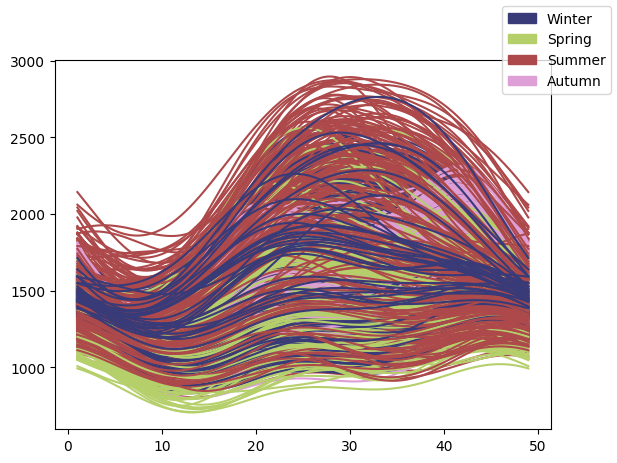

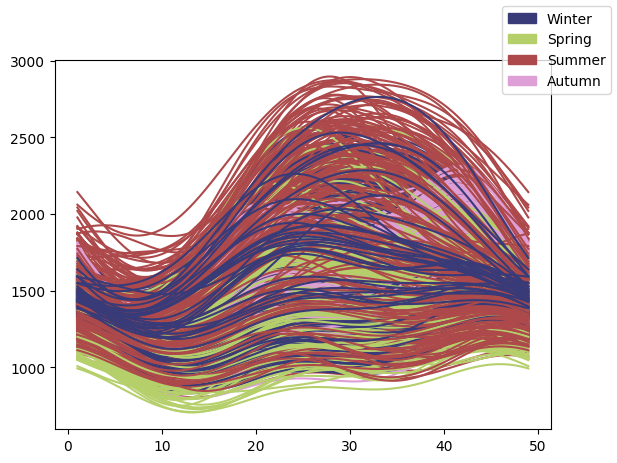

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skfda.representation.basis import FourierBasis
from skfda.representation.grid import FDataGrid
import pandas as pd
from datetime import datetime, timedelta

# Function to generate a list of dates
def generate_dates(start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, "%d/%m/%Y")
    end_date = datetime.strptime(end_date_str, "%d/%m/%Y")
    date_list = []
    one_day = timedelta(days=1)
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += one_day
    return date_list

# Function to get the season for Australia
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Summer'
    elif date.month in [3, 4, 5]:
        return 'Autumn'
    elif date.month in [6, 7, 8]:
        return 'Winter'
    elif date.month in [9, 10, 11]:
        return 'Spring'

# Create a DataFrame with a single column identifying the season
def create_season_df(start_date, end_date):
    dates = generate_dates(start_date, end_date)
    seasons = [get_season(date) for date in dates]
    
    # Create a DataFrame with dates and corresponding seasons
    df = pd.DataFrame({'Date': dates, 'Season': seasons})
    
    return df

# Define the date range
start_date = "06/07/1997"
end_date = "31/03/2007"

# Convert the 'Category' column to categorical and then to integer codes
season_df = create_season_df(start_date, end_date)
season_df['Category_Int'] = pd.Categorical(season_df['Season']).codes

# Assigning the color to each of the groups
colormap = plt.cm.get_cmap('tab20b')
unique_seasons = season_df['Season'].unique()
season_to_color = {season: colormap(i / (len(unique_seasons) - 1)) for i, season in enumerate(unique_seasons)}

# Convert the 'Season' string column to integer codes for grouping
season_df['Season_Int'] = season_df['Season'].astype('category').cat.codes

# Load temperature data
temp_data = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity/elect.csv').to_numpy()
temp_fd = FDataGrid(temp_data, range(1, 49))
temp_basis = FourierBasis(domain_range=(1, 49), n_basis=5)
fd = temp_fd.to_basis(temp_basis)

# Convert group_names to a list
group_names = list(season_to_color.keys())
group_colors = [season_to_color[season] for season in unique_seasons]
fd.plot(group=season_df['Season_Int'].values, group_names=group_names, group_colors=group_colors)

## Coefficient Extraction

In [21]:
elect_coefs = fd.coefficients
pd.DataFrame(elect_coefs).to_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_coefs.csv', index=False)

elect_accelaration_coefs = fd.derivative().derivative().coefficients
pd.DataFrame(elect_accelaration_coefs).to_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_acc_coefs.csv', index=False)

## Basis Matrix Extraction

In [34]:
# Define the points where we want to evaluate the basis functions
evaluation_points = np.linspace(0, 1, 100)
# Evaluate the basis functions at the specified points
basis_matrix = temp_basis.evaluate(evaluation_points)
basis_matrix_df = pd.DataFrame(basis_matrix.reshape((5,100)))
basis_matrix_df
basis_matrix_df.to_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_basis_matrix.csv', index=False)

/var/folders/4s/27tq7phd6bvg75xgn1b9vk7w0000gn/T/ipykernel_20913/1048689342.py:4: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_matrix = temp_basis.evaluate(evaluation_points)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,...,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338,0.144338
1,0.000000,0.000270,0.000540,0.000810,0.001080,0.001349,0.001619,0.001889,0.002159,0.002429,...,0.024233,0.024501,0.024769,0.025037,0.025305,0.025573,0.025841,0.026108,0.026376,0.026644
2,0.204124,0.204124,0.204123,0.204123,0.204121,0.204120,0.204118,0.204115,0.204113,0.204110,...,0.202681,0.202648,0.202616,0.202583,0.202550,0.202516,0.202482,0.202448,0.202413,0.202378
3,0.000000,0.000540,0.001080,0.001619,0.002159,0.002699,0.003239,0.003778,0.004318,0.004858,...,0.048124,0.048649,0.049173,0.049696,0.050220,0.050743,0.051265,0.051788,0.052310,0.052831
4,0.204124,0.204123,0.204121,0.204118,0.204113,0.204106,0.204098,0.204089,0.204078,0.204066,...,0.198370,0.198242,0.198113,0.197982,0.197850,0.197717,0.197582,0.197445,0.197308,0.197169


# First Model

This is going to be our first version of the FNN, using only temperature and electricity demand curves.

In [2]:
temp_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_coefs.csv').to_numpy()
elect_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_coefs.csv').to_numpy()
labels = pd.read_csv('/Users/tomas/Repos/FNNs/data/labels/labels.csv').drop(columns=['Date']).to_numpy()
labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

class CustomDataset(Dataset):
    def __init__(self, temp_coefs, elect_coefs, labels):
        self.temp_coefs = temp_coefs
        self.elect_coefs = elect_coefs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        temp_vector = self.temp_coefs[idx]
        elect_vector = self.elect_coefs[idx]
        label = self.labels[idx]
        return (temp_vector, elect_vector), label

# Create dataset
dataset = CustomDataset(temp_coefs, elect_coefs, labels)
generator = torch.Generator().manual_seed(42)

# Dataset splits
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # The rest for testing

# Create DataLoaders for each split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [38]:
class FunctionalLayer(nn.Module):
    def __init__(self, B, S, support, basis_fn_cnt):
        super(FunctionalLayer, self).__init__()
        # Grid for the support T (e.g., hours)
        self.grid = torch.linspace(support[0], support[1], 100)
        # Functional Object Basis Matrix
        self.B = B.float()
        # Φ Matrix
        self.S = S.float()
        # We don't need gradients for the splines
        self.B.requires_grad_(False)
        self.S.requires_grad_(False)

    def forward(self, X):
        # Obtain x(t)
        functional_data = torch.matmul(X, self.B).unsqueeze(1)
        # Φ(t) • x(t)
        S = self.S.unsqueeze(0)
        integrand = S * functional_data
        # Approximate the integral
        integral = torch.trapz(integrand, self.grid, dim=-1)
        return integral
        

class FNN(nn.Module):
    def __init__(self, temp_basis_matrix, beta_mat_temp, temp_ranges, elect_basis_matrix, beta_mat_elect, elect_ranges,basis_fn_cnt):
        super(FNN, self).__init__()
        # Functional sections, which estimate the integrals
        self.temp_layer = FunctionalLayer(temp_basis_matrix, beta_mat_temp, temp_ranges, basis_fn_cnt)
        self.elect_layer = FunctionalLayer(elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt)
        
        # Feed Forward Section & it's Norm
        self.fc1 = nn.Linear(10, 48)
        self.fc_norm_1 = nn.LayerNorm(48, bias=True, elementwise_affine=True)
        # Add dropout for the Feed Forward training
        self.dropout = torch.nn.Dropout(p=0.20)
        # Output Layer
        self.fc2 = nn.Linear(48, 4)

    def forward(self, X, training=True):
        # Process in set of Functional Coefficients to obtain integrals
        temp_res = self.temp_layer(X[0].float())
        elect_res = self.elect_layer(X[1].float())
        
        # Concatenate the Integrals
        X = torch.cat((temp_res, elect_res), dim=1)

        # Standardize it
        mean = X.mean(dim=0, keepdim=True)
        std = X.std(dim=0, keepdim=True)
        X = (X - mean) / std

        # Pass through Feed Forward
        X = self.fc1(X)
        X = self.dropout(torch.relu(self.fc_norm_1(X)))

        # Output layer
        return self.fc2(X)

In [39]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_stats = {'epoch': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for (temp_vectors, elect_vectors), batch_labels in train_loader:
            optimizer.zero_grad()
            # Forward pass
            outputs = model((temp_vectors, elect_vectors))
            # Compute loss
            loss = criterion(outputs, batch_labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (temp_vectors, elect_vectors), val_labels in val_loader:
                val_outputs = model((temp_vectors, elect_vectors))
                val_loss += criterion(val_outputs, val_labels).item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Store the epoch number, training loss, and validation loss
        loss_stats['epoch'].append(epoch + 1)
        loss_stats['train_loss'].append(avg_train_loss)
        loss_stats['val_loss'].append(avg_val_loss)

    return loss_stats

In [40]:
# Load Input Basis Matrix, which are used to generate the functional observations
temp_basis_matrix = torch.from_numpy(pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_basis_matrix.csv').to_numpy())
elect_basis_matrix = torch.from_numpy(pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_basis_matrix.csv').to_numpy())

# Build B-Splines Electricity, which is the corresponding Φ(t)
# Do notice we use 100 in np.linspace, the higher the number the better
# the integral approximation is.
beta_basis_elect = BSplineBasis((1,48), n_basis=5)
beta_matrix_elect = beta_basis_elect(np.linspace(*(1,48), 100)).reshape(5,100)
beta_mat_elect = torch.from_numpy(beta_matrix_elect).float()

# Build B-Splines Temperature, which is the corresponding Φ(t).
# Do notice we use 100 in np.linspace, the higher the number the better
# the integral approximation is.
beta_basis_temp = BSplineBasis((1,48), n_basis=5)
beta_matrix_temp = beta_basis_temp(np.linspace(*(1,48), 100)).reshape(5,100)
beta_mat_temp = torch.from_numpy(beta_matrix_temp).float()

# Create and train the FNN
net = FNN(temp_basis_matrix, beta_mat_temp, [1,48], elect_basis_matrix, beta_mat_elect, [1,48], 5)
loss_history = train_model(net, train_loader, val_loader, epochs=2800, lr=0.0007)

Epoch [1/2800], Train Loss: 1.2306, Val Loss: 1.0779
Epoch [2/2800], Train Loss: 1.0841, Val Loss: 0.9889
Epoch [3/2800], Train Loss: 1.0245, Val Loss: 0.9456
Epoch [4/2800], Train Loss: 1.0061, Val Loss: 0.9226
Epoch [5/2800], Train Loss: 0.9754, Val Loss: 0.9046
Epoch [6/2800], Train Loss: 0.9648, Val Loss: 0.8946
Epoch [7/2800], Train Loss: 0.9566, Val Loss: 0.8802
Epoch [8/2800], Train Loss: 0.9356, Val Loss: 0.8723
Epoch [9/2800], Train Loss: 0.9350, Val Loss: 0.8603
Epoch [10/2800], Train Loss: 0.9164, Val Loss: 0.8593
Epoch [11/2800], Train Loss: 0.9132, Val Loss: 0.8490
Epoch [12/2800], Train Loss: 0.9082, Val Loss: 0.8481
Epoch [13/2800], Train Loss: 0.8977, Val Loss: 0.8414
Epoch [14/2800], Train Loss: 0.9028, Val Loss: 0.8376
Epoch [15/2800], Train Loss: 0.9053, Val Loss: 0.8308
Epoch [16/2800], Train Loss: 0.8886, Val Loss: 0.8322
Epoch [17/2800], Train Loss: 0.8849, Val Loss: 0.8301
Epoch [18/2800], Train Loss: 0.8845, Val Loss: 0.8285
Epoch [19/2800], Train Loss: 0.8784, 

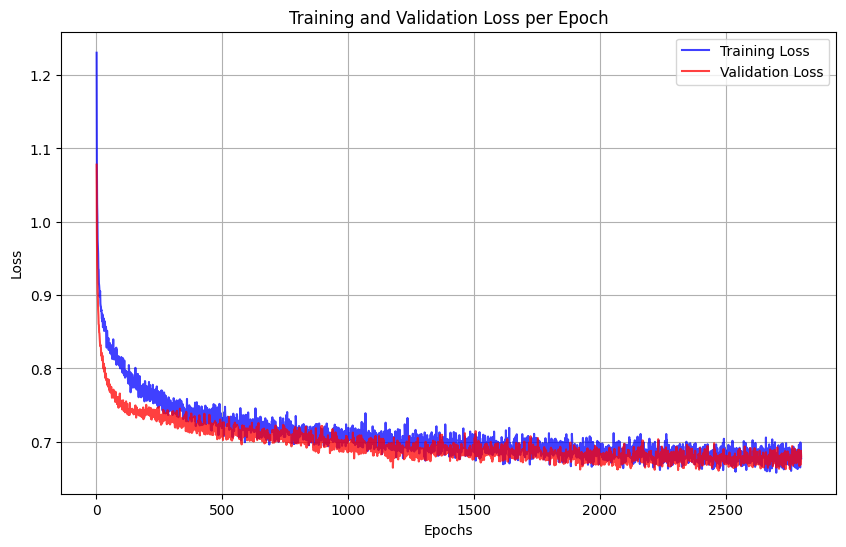

In [41]:
import matplotlib.pyplot as plt

def plot_loss_curves(loss_history):
    epochs = loss_history['epoch']
    train_loss = loss_history['train_loss']
    val_loss = loss_history['val_loss']
    
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', alpha=0.75)
    
    # Plot validation loss
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', alpha=0.75)
    
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    
    # Display legend
    plt.legend()

    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()


plot_loss_curves(loss_history)

Validation Accuracy: 70.0%


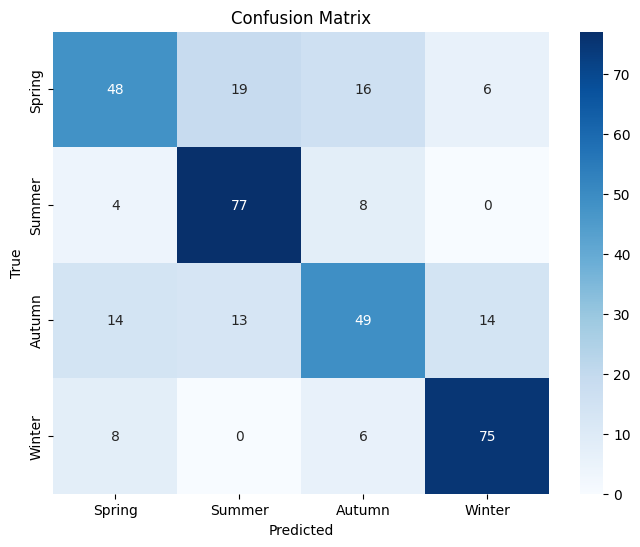

In [42]:
import seaborn
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def validate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for (temp_vectors, elect_vectors), batch_labels in test_loader:
            # Forward pass
            outputs = model((temp_vectors, elect_vectors))
            _, predicted = torch.max(outputs, 1)

            if batch_labels.ndim > 1:
                _, batch_labels = torch.max(batch_labels, 1)

            # Collect labels and predictions
            all_labels.extend(batch_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute accuracy
    accuracy = 100 * round(sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels), 2)
    print(f'Validation Accuracy: {accuracy}%')

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Spring', 'Summer', 'Autumn', 'Winter'], yticklabels=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


validate_model(net, test_loader)

## Weigth Function Analysis

Another advantdge of FNNs is that because we estimate the weight function we can actually see what the network is giving importance to. It's a "unique" perk of the FNNs, this can be use to validate your own thoughts about the data and where the variability that explains the data is present. However, keep in mind that the FNN might estimate different functions across different runs.

### Temperature Weigth Function

Given the weigth curve estimated by the the FNN we can see it's attributing most importance is given to the earlier hours of the day, since that's when i's the most distant from 0.0. However, importance grows again at the later hours of the day too.

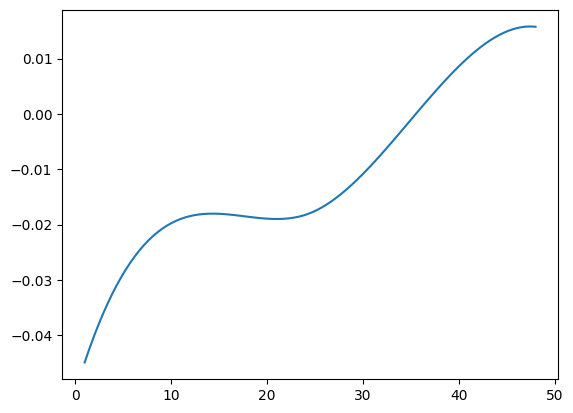

In [43]:
beta_splines = net.temp_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[0:5]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Electricity Weigth Function

The electricity demand curve seems ot have the most importance since 0 doesn't even show on the Y-axis. However, the peak of importance is between 30 to 40, which corresponds to 3PM to 8PM. 

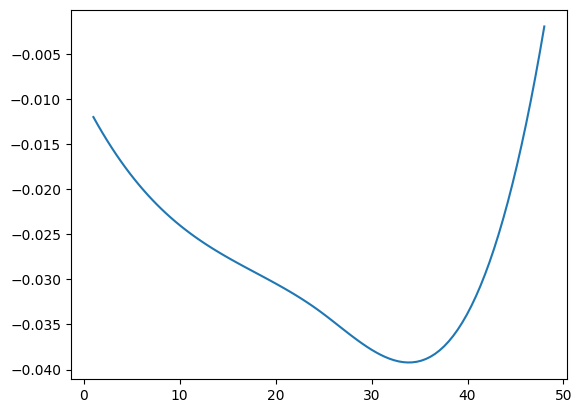

In [44]:
beta_splines = net.elect_layer.S.detach().numpy()
elect_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[5:]
res = np.dot(beta_splines.T, elect_coefs)
plt.plot(np.linspace(1, 48, 100), res)

# Second Model

This will be our second model, which will add the second derivates for both temperature and electricity demand. The objectives is to extract more meaning from these features and hopefully help our FNN perform better.

In [28]:
temp_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_coefs.csv').to_numpy()
elect_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_coefs.csv').to_numpy()
temp_acc_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_acc_coefs.csv').to_numpy()
elect_acc_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_acc_coefs.csv').to_numpy()
labels = pd.read_csv('/Users/tomas/Repos/FNNs/data/labels/labels.csv').drop(columns=['Date']).to_numpy()
labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [29]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

class CustomDataset(Dataset):
    def __init__(self, temp_coefs, elect_coefs, temp_acc_coefs, elect_acc_coefs, labels):
        self.temp_coefs = temp_coefs
        self.elect_coefs = elect_coefs
        self.temp_acc_coefs = temp_acc_coefs
        self.elect_acc_coefs = elect_acc_coefs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        temp_vector = self.temp_coefs[idx]
        elect_vector = self.elect_coefs[idx]
        temp_acc_vector = self.temp_acc_coefs[idx]
        elect_acc_vector = self.elect_acc_coefs[idx]
        label = self.labels[idx]
        return (temp_vector, elect_vector, temp_acc_vector, elect_acc_vector), label

# Create dataset
dataset = CustomDataset(temp_coefs, elect_coefs, temp_acc_coefs, elect_acc_coefs, labels)
generator = torch.Generator().manual_seed(42)

# Dataset splits
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # The rest for testing

# Create DataLoaders for each split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle training data per epoch
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [108]:
class FunctionalLayer(nn.Module):
    def __init__(self, B, S, support, basis_fn_cnt):
        super(FunctionalLayer, self).__init__()
        # Grid for the support T (e.g., hours)
        self.grid = torch.linspace(support[0], support[1], 100)
        # Functional Object Basis Matrix
        self.B = B.float()
        # Φ Matrix
        self.S = S.float()
        # We don't need gradients for the splines
        self.B.requires_grad_(False)
        self.S.requires_grad_(False)

    def forward(self, X):
        # Obtain x(t)
        functional_data = torch.matmul(X, self.B).unsqueeze(1)
        # Φ(t) • x(t)
        S = self.S.unsqueeze(0)
        integrand = S * functional_data
        # Approximate the integral
        integral = torch.trapz(integrand, self.grid, dim=-1)
        return integral
        

class FNN(nn.Module):
    def __init__(self, temp_basis_matrix, beta_mat_temp, temp_ranges,
                 elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt):
        super(FNN, self).__init__()
        # Functional sections, which estimate the integrals
        self.temp_layer = FunctionalLayer(temp_basis_matrix, beta_mat_temp, temp_ranges, basis_fn_cnt)
        self.elect_layer = FunctionalLayer(elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt)
        self.temp_acc_layer = FunctionalLayer(temp_basis_matrix, beta_mat_temp, temp_ranges, basis_fn_cnt)
        self.elect_acc_layer = FunctionalLayer(elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt)

        # Feed Forward Section & it's Norm
        self.fc1 = nn.Linear(20, 48)
        self.fc_norm_1 = nn.LayerNorm(48, bias=True, elementwise_affine=True)
        self.fc2 = nn.Linear(48, 32)
        self.fc_norm_2 = nn.LayerNorm(32, bias=False, elementwise_affine=True)
        # Add dropout for the Feed Forward training
        self.dropout_1 = torch.nn.Dropout(p=0.33)
        self.dropout_2 = torch.nn.Dropout(p=0.25)
        # Output Layer
        self.fc3 = nn.Linear(32, 4)

    def forward(self, X, training=True):
        # Process set of Functional Coefficients to obtain integrals
        temp_res = self.temp_layer(X[0].float())
        elect_res = self.elect_layer(X[1].float())
        temp_acc_res = self.temp_acc_layer(X[2].float())
        elect_acc_res = self.elect_acc_layer(X[3].float())
        
        # Concatenate the Integrals
        X = torch.cat((temp_res, elect_res, temp_acc_res, elect_acc_res), dim=1)
        
        # Standardize it
        mean = X.mean(dim=0, keepdim=True)
        std = X.std(dim=0, keepdim=True)
        X = (X - mean) / std

        # Pass through Feed Forward
        X = self.fc1(X)
        X = self.dropout_1(torch.relu(self.fc_norm_1(X)))
        X = self.fc2(X)
        X = self.dropout_2(torch.relu(self.fc_norm_2(X)))

        # Output layer
        return self.fc3(X)

In [138]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_stats = {'epoch': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for (temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors), batch_labels in train_loader:
            optimizer.zero_grad()
            # Forward pass
            outputs = model((temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors))
            # Compute loss
            loss = criterion(outputs, batch_labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors), val_labels in val_loader:
                val_outputs = model((temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors))
                val_loss += criterion(val_outputs, val_labels).item()
        
        # Calculate average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Store the epoch number, training loss, and validation loss
        loss_stats['epoch'].append(epoch + 1)
        loss_stats['train_loss'].append(avg_train_loss)
        loss_stats['val_loss'].append(avg_val_loss)

    return loss_stats

In [139]:
# Load Input Basis Matrix, which are used to generate the functional observations
temp_basis_matrix = torch.from_numpy(pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_basis_matrix.csv').to_numpy())
elect_basis_matrix = torch.from_numpy(pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_basis_matrix.csv').to_numpy())

# Build B-Splines Electricity, which is the corresponding Φ(t)
# Do notice we use 100 in np.linspace, the higher the number the better
# the integral approximation is.
beta_basis_elect = BSplineBasis((1,48), n_basis=5)
beta_matrix_elect = beta_basis_elect(np.linspace(*(1,48), 100)).reshape(5,100)
beta_mat_elect = torch.from_numpy(beta_matrix_elect).float()

# Build B-Splines Temperature, which is the corresponding Φ(t).
# Do notice we use 100 in np.linspace, the higher the number the better
# the integral approximation is.
beta_basis_temp = BSplineBasis((1,48), n_basis=5)
beta_matrix_temp = beta_basis_temp(np.linspace(*(1,48), 100)).reshape(5,100)
beta_mat_temp = torch.from_numpy(beta_matrix_temp).float()

# Create and train the FNN
net = FNN(temp_basis_matrix, beta_mat_temp, [1,48], elect_basis_matrix, beta_mat_elect, [1,48], 5)
loss_history = train_model(net, train_loader, val_loader, epochs=1500, lr=0.0007)

Epoch [1/1500], Train Loss: 1.2925, Val Loss: 1.0816
Epoch [2/1500], Train Loss: 1.1027, Val Loss: 0.9371
Epoch [3/1500], Train Loss: 1.0179, Val Loss: 0.8797
Epoch [4/1500], Train Loss: 0.9846, Val Loss: 0.8421
Epoch [5/1500], Train Loss: 0.9533, Val Loss: 0.8148
Epoch [6/1500], Train Loss: 0.9189, Val Loss: 0.7962
Epoch [7/1500], Train Loss: 0.9083, Val Loss: 0.7774
Epoch [8/1500], Train Loss: 0.8914, Val Loss: 0.7694
Epoch [9/1500], Train Loss: 0.8869, Val Loss: 0.7706
Epoch [10/1500], Train Loss: 0.8886, Val Loss: 0.7584
Epoch [11/1500], Train Loss: 0.8789, Val Loss: 0.7505
Epoch [12/1500], Train Loss: 0.8662, Val Loss: 0.7436
Epoch [13/1500], Train Loss: 0.8620, Val Loss: 0.7434
Epoch [14/1500], Train Loss: 0.8630, Val Loss: 0.7346
Epoch [15/1500], Train Loss: 0.8507, Val Loss: 0.7296
Epoch [16/1500], Train Loss: 0.8595, Val Loss: 0.7389
Epoch [17/1500], Train Loss: 0.8548, Val Loss: 0.7383
Epoch [18/1500], Train Loss: 0.8576, Val Loss: 0.7382
Epoch [19/1500], Train Loss: 0.8492, 

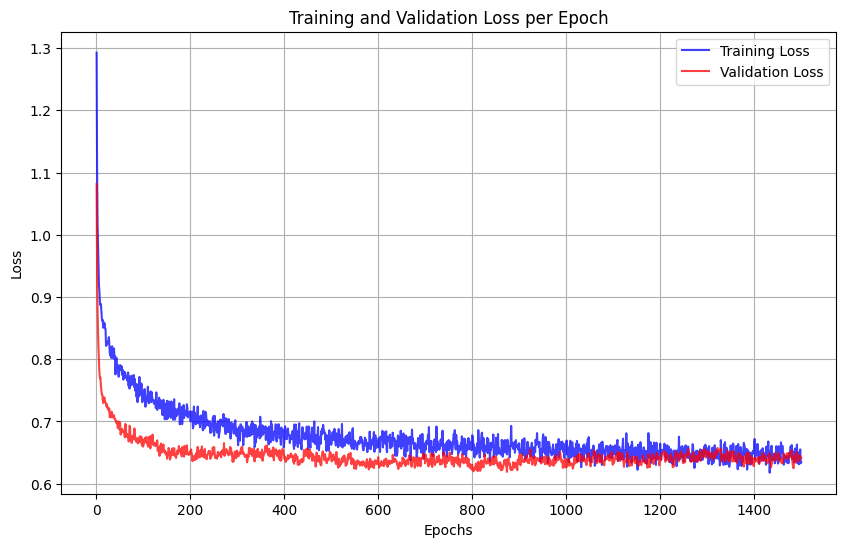

In [146]:
import matplotlib.pyplot as plt

def plot_loss_curves(loss_history):
    epochs = loss_history['epoch']
    train_loss = loss_history['train_loss']
    val_loss = loss_history['val_loss']
    
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', alpha=0.75)
    # Plot validation loss
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', alpha=0.75)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss_curves(loss_history)

Validation Accuracy: 73.0%


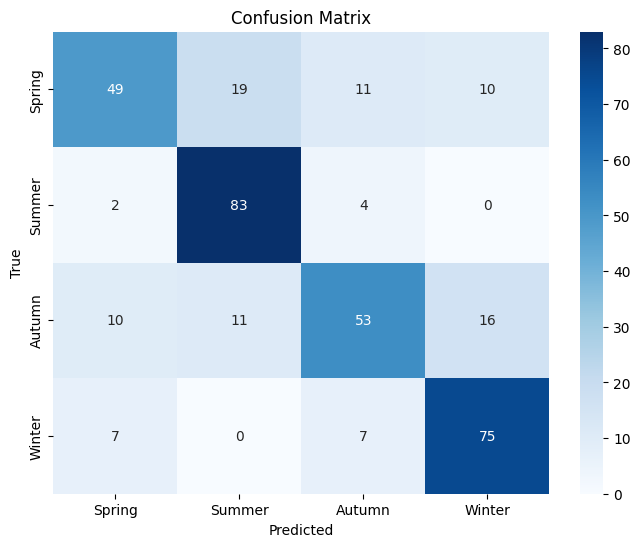

In [141]:
import seaborn
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def validate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for (temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors), batch_labels in test_loader:
            # Forward pass
            outputs = model((temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors))
            _, predicted = torch.max(outputs, 1)

            if batch_labels.ndim > 1:
                _, batch_labels = torch.max(batch_labels, 1)

            # Collect labels and predictions
            all_labels.extend(batch_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute accuracy
    accuracy = 100 * round(sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels), 2)
    print(f'Validation Accuracy: {accuracy}%')

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Spring', 'Summer', 'Autumn', 'Winter'], yticklabels=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


validate_model(net, test_loader)

## Weigth Function Analysis

### Temperature Weigth Function

We can see that the temperature's weigth function change quite a bit, at it least in scale, which is now positive. However, it's the earlier hours of the day that carry the most importance.

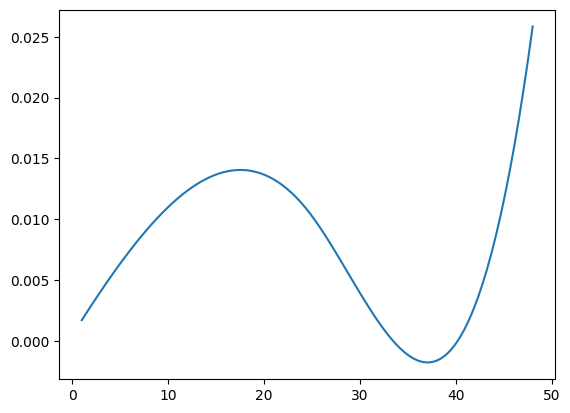

In [142]:
beta_splines = net.temp_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[0:5]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Electricity Weigth Function

The electricity weigth function seems to have a similar-ish shape. Especially, since it's the later hours of the day - around 3PM - that have the most importance.

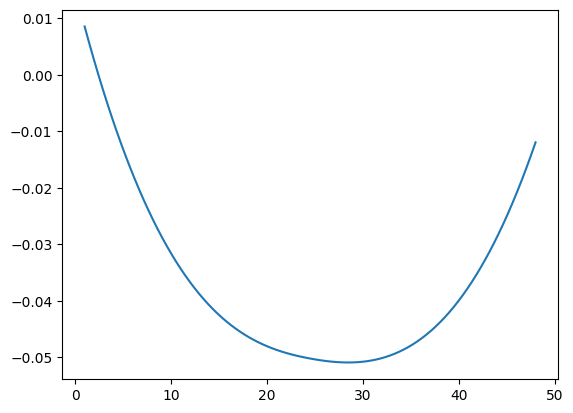

In [143]:
beta_splines = net.elect_layer.S.detach().numpy()
elect_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[5:10]
res = np.dot(beta_splines.T, elect_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Temperature Acceleration Weigth Function

The temperature accelartion seems to have follow the temperature curve's importance. Since the earlier of the day carry the most importance. This probablyone of the reasons our FNN didn't improve much. Essentially, there isn't that much information encoded in this variable.

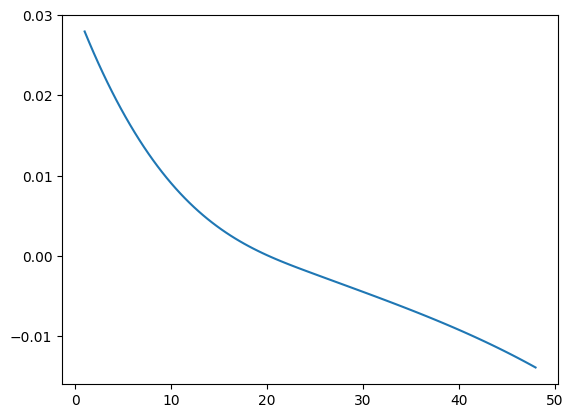

In [144]:
beta_splines = net.temp_acc_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[10:15]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

# Third Model

This is our third and final model, which is going to incorporate the Functional Latent Factors.

In [35]:
# Assuming fdata_basis is an FDataBasis object
fdata_basis = FourierBasis(domain_range=(0, 1), n_basis=5)
eval_points = np.linspace(0, 1, 100)

# Evaluate the basis matrix at the desired points
basis_matrix = fdata_basis(eval_points)
pd.DataFrame(basis_matrix.reshape(5,100)).to_csv('/Users/tomas/Repos/FNNs/data/Latent_Factors/latent_basis.csv', index=False)

In [2]:
temp_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_coefs.csv').to_numpy()
elect_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_coefs.csv').to_numpy()
temp_acc_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_acc_coefs.csv').to_numpy()
elect_acc_coefs = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_acc_coefs.csv').to_numpy()
temp_data = pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperatures/temp.csv').to_numpy()
elect_data = pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity/elect.csv').to_numpy()
labels = pd.read_csv('/Users/tomas/Repos/FNNs/data/labels/labels.csv').drop(columns=['Date']).to_numpy()
labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

class CustomDataset(Dataset):
    def __init__(self, temp_coefs, elect_coefs, temp_acc_coefs, elect_acc_coefs, temp_data, elect_data, labels):
        self.temp_coefs = temp_coefs
        self.elect_coefs = elect_coefs
        self.temp_acc_coefs = temp_acc_coefs
        self.elect_acc_coefs = elect_acc_coefs
        self.temp_data = temp_data
        self.elect_data = elect_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        temp_vector = self.temp_coefs[idx]
        elect_vector = self.elect_coefs[idx]
        temp_acc_vector = self.temp_acc_coefs[idx]
        elect_acc_vector = self.elect_acc_coefs[idx]
        temp_data = self.temp_data[idx]
        elect_data = self.elect_data[idx]
        label = self.labels[idx]
        return (temp_vector, elect_vector, temp_acc_vector, elect_acc_vector, temp_data, elect_data), label

# Create dataset
dataset = CustomDataset(temp_coefs, elect_coefs, temp_acc_coefs, elect_acc_coefs, temp_data, elect_data, labels)
generator = torch.Generator().manual_seed(42)

# Dataset splits
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # The rest for testing

# Create DataLoaders for each split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
class FunctionalLayer(nn.Module):
    def __init__(self, B, S, support, basis_fn_cnt):
        super(FunctionalLayer, self).__init__()
        # Grid for the support T (e.g., hours)
        self.grid = torch.linspace(support[0], support[1], 100)
        # Functional Object Basis Matrix
        self.B = B.float()
        # Φ Matrix
        self.S = S.float()
        # We don't need gradients for the splines
        self.B.requires_grad_(False)
        self.S.requires_grad_(False)

    def forward(self, X):
        # Obtain x(t)
        functional_data = torch.matmul(X, self.B).unsqueeze(1)
        # Φ(t) • x(t)
        S = self.S.unsqueeze(0)
        # Approximate the integral
        integrand = S * functional_data
        integral = torch.trapz(integrand, self.grid, dim=-1)
        return integral
        

class FNN(nn.Module):
    def __init__(self, temp_basis_matrix, beta_mat_temp, temp_ranges,
                 elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt):
        super(FNN, self).__init__()
        # Functional sections, which estimate the integrals
        self.temp_layer = FunctionalLayer(temp_basis_matrix, beta_mat_temp, temp_ranges, basis_fn_cnt)
        self.elect_layer = FunctionalLayer(elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt)
        self.temp_acc_layer = FunctionalLayer(temp_basis_matrix, beta_mat_temp, temp_ranges, basis_fn_cnt)
        self.elect_acc_layer = FunctionalLayer(elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt)
        self.latent_temp_layer = FunctionalLayer(temp_basis_matrix, beta_mat_temp, temp_ranges, basis_fn_cnt)
        self.latent_elect_layer = FunctionalLayer(elect_basis_matrix, beta_mat_elect, elect_ranges, basis_fn_cnt)

        # Latent Factor Transformations Matrices
        self.gamma = nn.Linear(48, 12)
        self.lambda_temp = nn.Linear(12, 5)
        self.lambda_elect = nn.Linear(12, 5)
        
        # Feed Forward Section & it's Norm
        self.fc1 = nn.Linear(30, 48)
        self.fc_norm_1 = nn.LayerNorm(48, bias=True, elementwise_affine=True)
        self.fc2 = nn.Linear(48, 24)
        self.fc_norm_2 = nn.LayerNorm(24, bias=True, elementwise_affine=True)
        # Add dropout for the Feed Forward training
        self.dropout_1 = torch.nn.Dropout(p=0.40)
        self.dropout_2 = torch.nn.Dropout(p=0.40)
        # Output Layer
        self.fc3 = nn.Linear(24, 4)

    def forward(self, X, training=True):
        # Latent Factor Transformation 
        latent_temp = self.gamma(X[4].float())
        latent_elect = self.gamma(X[5].float())
        latent_temp = self.lambda_temp(latent_temp)
        latent_elect = self.lambda_elect(latent_elect)
        
        # Process set of Functional Coefficients to obtain integrals
        temp_res = self.temp_layer(X[0].float())
        elect_res = self.elect_layer(X[1].float())
        temp_acc_res = self.temp_acc_layer(X[2].float())
        elect_acc_res = self.elect_acc_layer(X[3].float())
        latent_temp = self.latent_temp_layer(latent_temp)
        latent_elect = self.latent_elect_layer(latent_elect)
        
        # Concatenate the Integrals
        X = torch.cat((temp_res, elect_res, temp_acc_res, elect_acc_res, latent_temp, latent_elect), dim=1)
        
        # Standardize it
        mean = X.mean(dim=0, keepdim=True)
        std = X.std(dim=0, keepdim=True)
        X = (X - mean) / std

        # Pass through Feed Forward
        X = self.fc1(X)
        X = self.dropout_1(torch.relu(self.fc_norm_1(X)))
        X = self.fc2(X)
        X = self.dropout_2(torch.relu(self.fc_norm_2(X)))

        # Output layer
        return self.fc3(X)

In [14]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, weight_decay=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_stats = {'epoch': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for (temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors, temp_data, elect_data), batch_labels in train_loader:
            optimizer.zero_grad()
            # Forward pass
            outputs = model((temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors, temp_data, elect_data))
            # Compute loss
            loss = criterion(outputs, batch_labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step() 
            running_loss += loss.item()
        
        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors, temp_data, elect_data), val_labels in val_loader:
                val_outputs = model((temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors, temp_data, elect_data))
                val_loss += criterion(val_outputs, val_labels).item()
        
        # Calculate average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Store the epoch number, training loss, and validation loss
        loss_stats['epoch'].append(epoch + 1)
        loss_stats['train_loss'].append(avg_train_loss)
        loss_stats['val_loss'].append(avg_val_loss)

    return loss_stats

In [15]:
# Load Input Basis Matrix, which are used to generate the functional observations
temp_basis_matrix = torch.from_numpy(pd.read_csv('/Users/tomas/Repos/FNNs/data/Temperature_Coefficients/temp_basis_matrix.csv').to_numpy())
elect_basis_matrix = torch.from_numpy(pd.read_csv('/Users/tomas/Repos/FNNs/data/Electricity_Coefficients/elect_basis_matrix.csv').to_numpy())

# Build B-Splines Electricity, which is the corresponding Φ(t)
# Do notice we use 100 in np.linspace, the higher the number the better
# the integral approximation is.
beta_basis_elect = BSplineBasis((1,48), n_basis=5)
beta_matrix_elect = beta_basis_elect(np.linspace(*(1,48), 100)).reshape(5,100)
beta_mat_elect = torch.from_numpy(beta_matrix_elect).float()

# Build B-Splines Temperature, which is the corresponding Φ(t).
# Do notice we use 100 in np.linspace, the higher the number the better
# the integral approximation is.
beta_basis_temp = BSplineBasis((1,48), n_basis=5)
beta_matrix_temp = beta_basis_temp(np.linspace(*(1,48), 100)).reshape(5,100)
beta_mat_temp = torch.from_numpy(beta_matrix_temp).float()

# Create and train the FNN
net = FNN(temp_basis_matrix, beta_mat_temp, [1,48], elect_basis_matrix, beta_mat_elect, [1,48], 5)
loss_history = train_model(net, train_loader, val_loader, epochs=700, lr=0.0005)

Epoch [1/700], Train Loss: 1.3685, Val Loss: 1.1684
Epoch [2/700], Train Loss: 1.2150, Val Loss: 1.0405
Epoch [3/700], Train Loss: 1.1425, Val Loss: 0.9734
Epoch [4/700], Train Loss: 1.0914, Val Loss: 0.9267
Epoch [5/700], Train Loss: 1.0504, Val Loss: 0.8834
Epoch [6/700], Train Loss: 0.9948, Val Loss: 0.8213
Epoch [7/700], Train Loss: 0.9481, Val Loss: 0.7772
Epoch [8/700], Train Loss: 0.9281, Val Loss: 0.7494
Epoch [9/700], Train Loss: 0.8944, Val Loss: 0.7285
Epoch [10/700], Train Loss: 0.8793, Val Loss: 0.7217
Epoch [11/700], Train Loss: 0.8473, Val Loss: 0.6784
Epoch [12/700], Train Loss: 0.8517, Val Loss: 0.6621
Epoch [13/700], Train Loss: 0.8140, Val Loss: 0.7111
Epoch [14/700], Train Loss: 0.7879, Val Loss: 0.6539
Epoch [15/700], Train Loss: 0.8017, Val Loss: 0.6198
Epoch [16/700], Train Loss: 0.7675, Val Loss: 0.6225
Epoch [17/700], Train Loss: 0.7588, Val Loss: 0.6085
Epoch [18/700], Train Loss: 0.7510, Val Loss: 0.6132
Epoch [19/700], Train Loss: 0.7371, Val Loss: 0.5757
Ep

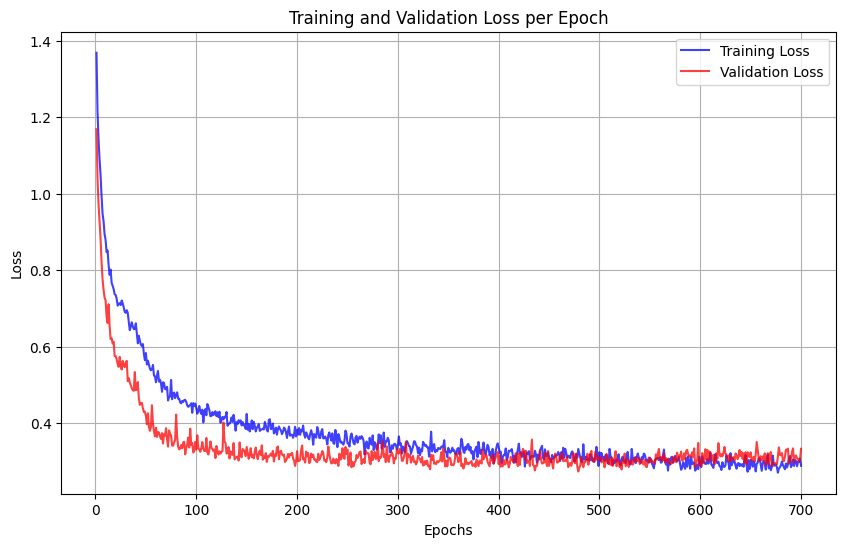

In [16]:
import matplotlib.pyplot as plt

def plot_loss_curves(loss_history):
    epochs = loss_history['epoch']
    train_loss = loss_history['train_loss']
    val_loss = loss_history['val_loss']
    
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', alpha=0.75)
    
    # Plot validation loss
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', alpha=0.75)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss_curves(loss_history)

Validation Accuracy: 90.0%


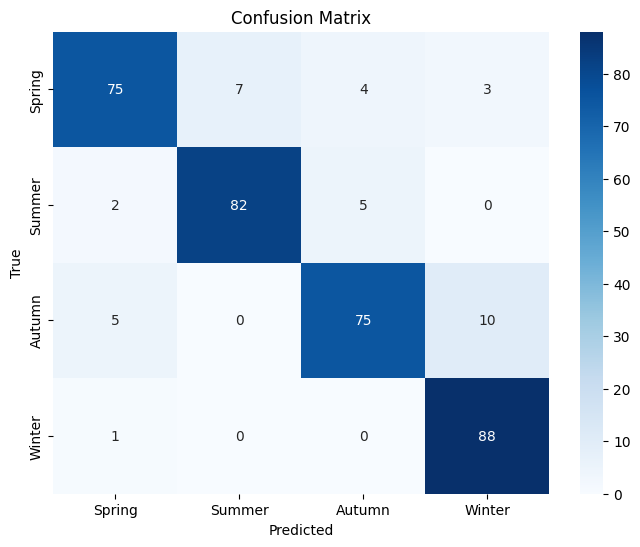

In [17]:
import seaborn
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def validate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for (temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors, temp_data, elect_data), batch_labels in test_loader:
            # Forward pass
            outputs = model((temp_vectors, elect_vectors, temp_acc_vectors, elect_acc_vectors, temp_data, elect_data))
            _, predicted = torch.max(outputs, 1)

            if batch_labels.ndim > 1:
                _, batch_labels = torch.max(batch_labels, 1)

            # Collect labels and predictions
            all_labels.extend(batch_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute accuracy
    accuracy = 100 * round(sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels), 2)
    print(f'Validation Accuracy: {accuracy}%')

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Spring', 'Summer', 'Autumn', 'Winter'], yticklabels=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


validate_model(net, test_loader)

## Weigth Function Analysis

### Temperature Weigth Function

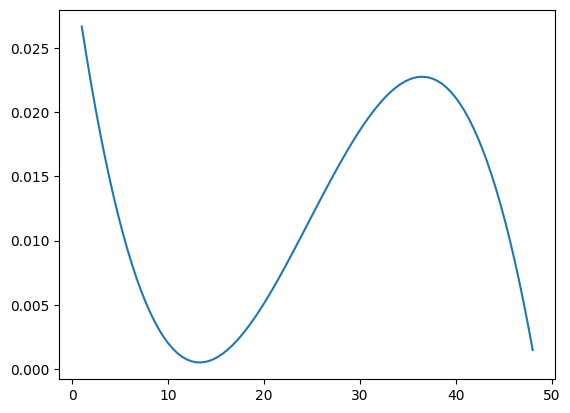

In [18]:
beta_splines = net.temp_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[0:5]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Electricity Weigth Function

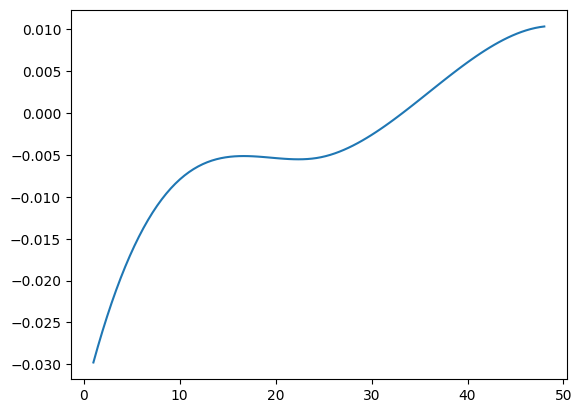

In [19]:
beta_splines = net.elect_layer.S.detach().numpy()
elect_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[5:10]
res = np.dot(beta_splines.T, elect_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Temperature Acceleration Weigth Function

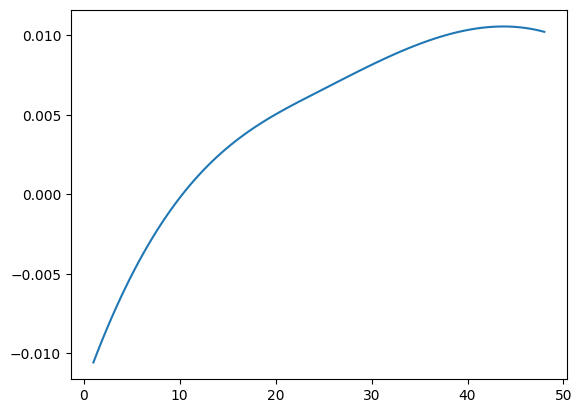

In [20]:
beta_splines = net.temp_acc_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[10:15]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Electricity Acceleration Weigth Function

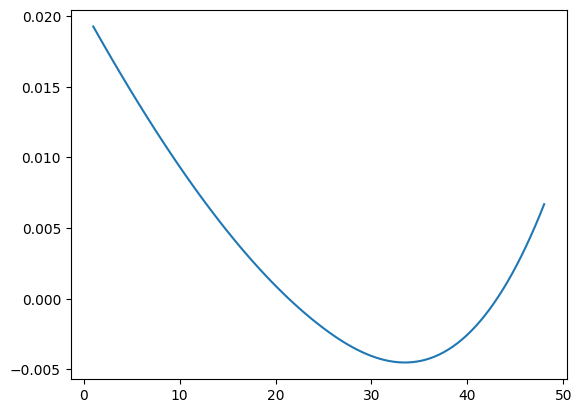

In [21]:
beta_splines = net.elect_acc_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[15:20]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Latent Temperature Factor Weigth Function

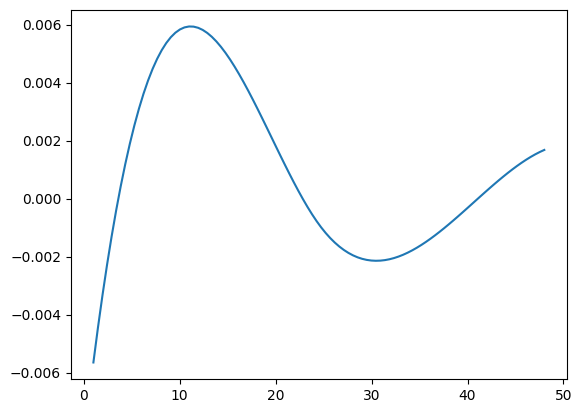

In [22]:
beta_splines = net.latent_temp_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[20:25]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)

### Latent Electricity Factor Weigth Function

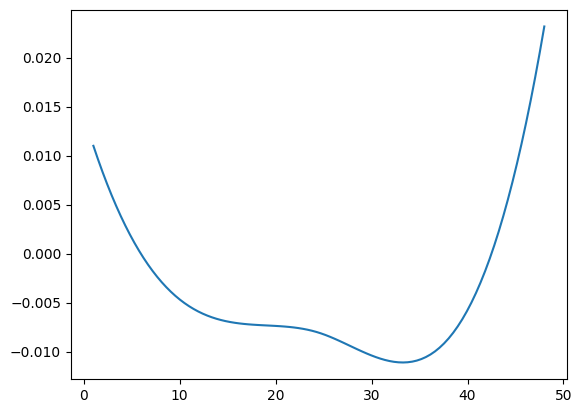

In [23]:
beta_splines = net.latent_elect_layer.S.detach().numpy()
temp_coefs = np.mean(net.fc1.weight.detach().numpy(), axis=0)[25:]
res = np.dot(beta_splines.T, temp_coefs)
plt.plot(np.linspace(1, 48, 100), res)